# Apple (AAPL) Time Series Analysis — (Classical + Deep Learning + Transformers)


- Data cleaning, missing timestamps, and consistent interval checks  
- Stationarity + transforms (log, differencing) + **ADF / KPSS**  
- Decomposition (additive idea via STL)  
- ACF / PACF + covariance vs autocovariance  
- Indicators: **SMA, CMA, EMA, RSI**  
- Baselines + walk-forward validation  
- Classical models: **AR / MA / ARMA / ARIMA / SARIMA**  
- Deep learning: **RNN / LSTM / 1D CNN** (PyTorch)  
- State-of-the-art: **Transformer Encoder** + **D-Linear** baseline  
- Multivariate + cross-correlation + Granger-causality style checks






In [ ]:
import warnings
warnings.filterwarnings("ignore")
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm



## 1) Load and Clean Apple Stock Data

Key ideas from the doc:
- Time series models assume a **consistent sampling interval** (don’t mix 1‑min and 5‑min points).
- Missing timestamps should be handled deliberately (resample + impute) and you should track imputed points to avoid “silent” data issues.


In [ ]:
DATA_PATH = "/content/A_AAPL_two_years.xlsx"
df_raw = pd.read_excel(DATA_PATH)

print("Raw shape:", df_raw.shape)
display(df_raw.head())

# ---------- Auto-detect date column ----------
def find_col(cols, candidates):
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    # fallback: search substrings
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in candidates):
            return c
    return None

date_col = find_col(df_raw.columns, ["date", "timestamp", "time"])
if date_col is None:
    raise ValueError("Could not auto-detect a date/time column. Rename your date column to 'Date'.")

# ---------- Parse date + sort ----------
df = df_raw.copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)
df = df.set_index(date_col)

# ---------- Auto-detect target price column ----------
price_col = find_col(df.columns, ["adj close", "adj_close", "close", "closing price", "price"])
if price_col is None:
    raise ValueError("Could not auto-detect a Close/Adj Close column. Rename it to 'Close' or 'Adj Close'.")

# Keep common columns if present
candidate_features = []
for c in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
    cc = find_col(df.columns, [c])
    if cc is not None and cc not in candidate_features:
        candidate_features.append(cc)

# Ensure numeric
for c in candidate_features:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[price_col])

print("Detected date col:", date_col)
print("Detected price col:", price_col)
print("Feature columns:", candidate_features)

# ---------- Frequency check & resampling ----------
# Many Apple datasets are daily (trading days). We'll resample to Business Day (B) index.
# This creates explicit missing days, which we can fill (and mark).
df = df[sorted(set(candidate_features), key=candidate_features.index)]  # preserve order
df = df[~df.index.duplicated(keep="last")]

# Create a complete Business Day index between min/max dates
full_index = pd.date_range(df.index.min(), df.index.max(), freq="B")
df_full = df.reindex(full_index)

# Mark missing rows introduced by resampling
df_full["was_missing"] = df_full[price_col].isna().astype(int)

# Basic imputation strategy (for finance daily data):
# - forward-fill prices and OHLC (safe-ish for small gaps like holidays)
# - volume: fill missing with 0 (or forward-fill; choose based on your dataset)
ffill_cols = [c for c in df.columns if c.lower() != "volume"]
vol_cols = [c for c in df.columns if c.lower() == "volume"]

df_full[ffill_cols] = df_full[ffill_cols].ffill()
if vol_cols:
    df_full[vol_cols] = df_full[vol_cols].fillna(0)

df = df_full.copy()
df.index.name = "Date"

print("After resample+impute:", df.shape)
print("Missing rows created (count):", int(df['was_missing'].sum()))
display(df.head())

Raw shape: (970, 14)


,Date,Open,High,Low,Close,Volume,Ticker,Company,SMA_20,EMA_20,RSI_14,BB_Middle,BB_Upper,BB_Lower
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Detected date col: Date
Detected price col: Close
Feature columns: ['Open', 'High', 'Low', 'Close', 'Volume']
After resample+impute: (506, 6)
Missing rows created (count): 21


,Open,High,Low,Close,Volume,was_missing
Date,,,,,,
2023-11-17,188.652815,188.781729,186.986926,188.097519,50922700.0,0
2023-11-20,188.295812,190.298857,188.285901,189.842712,46505100.0,0
2023-11-21,189.803075,189.912153,188.147097,189.039536,38134500.0,0
2023-11-22,189.882415,191.310313,189.227952,189.703918,39617700.0,0
2023-11-23,189.882415,191.310313,189.227952,189.703918,0.0,1


## 2) Quick EDA: Price, Log-Price, Returns

Stocks in **price level** often behave like a random walk (nonstationary).  
Returns (especially log-returns) are much closer to stationary and are usually better for modeling and testing.


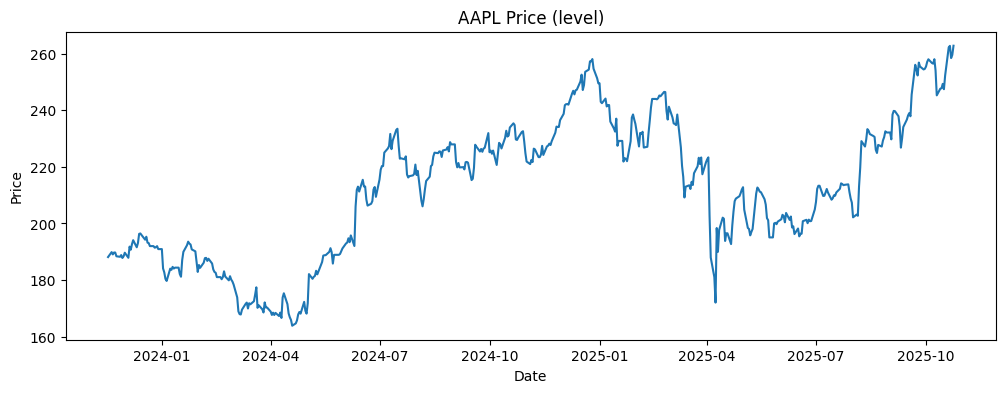

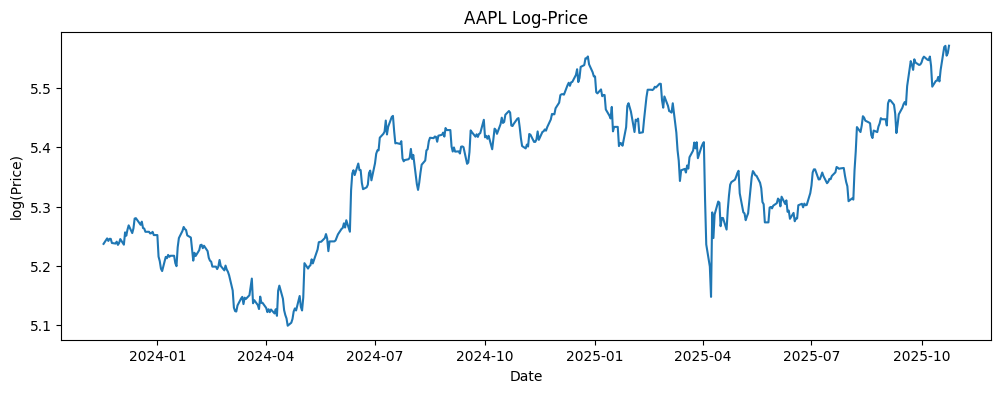

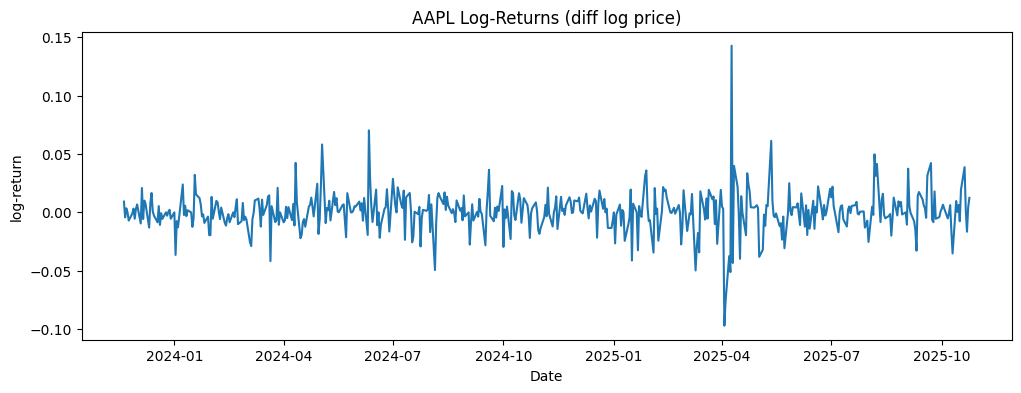

Return summary:


,Close
count,505.000000
mean,0.000662
std,0.017354
min,-0.097013
25%,-0.006686
50%,0.000580
75%,0.007790
max,0.142617


In [ ]:
# Core series
price = df[price_col].astype(float).copy()

log_price = np.log(price)
log_return = log_price.diff()
simple_return = price.pct_change()

# Plot
plt.figure(figsize=(12,4))
plt.plot(price)
plt.title("AAPL Price (level)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(log_price)
plt.title("AAPL Log-Price")
plt.xlabel("Date"); plt.ylabel("log(Price)")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(log_return)
plt.title("AAPL Log-Returns (diff log price)")
plt.xlabel("Date"); plt.ylabel("log-return")
plt.show()

print("Return summary:")
display(log_return.describe())

## 3) Stationarity Tests: ADF and KPSS (Level vs Returns)

Reminder (from the doc):
- **ADF** null hypothesis: **unit root** (nonstationary).
- **KPSS** null hypothesis: **stationary**.

Using both together gives a stronger conclusion.


In [ ]:
def adf_test(series, name="", regression="c", autolag="AIC"):
    series = series.dropna()
    stat, p, usedlag, nobs, crit, icbest = adfuller(series, regression=regression, autolag=autolag)
    return {
        "series": name, "ADF stat": stat, "p-value": p, "lags": usedlag, "nobs": nobs,
        "crit 1%": crit["1%"], "crit 5%": crit["5%"], "crit 10%": crit["10%"]
    }

def kpss_test(series, name="", regression="c", nlags="auto"):
    series = series.dropna()
    stat, p, lags, crit = kpss(series, regression=regression, nlags=nlags)
    return {
        "series": name, "KPSS stat": stat, "p-value": p, "lags": lags,
        "crit 10%": crit["10%"], "crit 5%": crit["5%"], "crit 2.5%": crit["2.5%"], "crit 1%": crit["1%"]
    }

tests = []
tests.append(adf_test(price, "Price (level)", regression="ct"))   # allow trend in level
tests.append(adf_test(log_return, "Log-Return", regression="c"))

ktests = []
ktests.append(kpss_test(price, "Price (level)", regression="ct"))
ktests.append(kpss_test(log_return, "Log-Return", regression="c"))

print("ADF results")
display(pd.DataFrame(tests))

print("KPSS results")
display(pd.DataFrame(ktests))

# Differencing example
diff_price = price.diff()
print("ADF on diff(price):")
display(pd.DataFrame([adf_test(diff_price, "diff(price)", regression="c")]))

ADF results


,series,ADF stat,p-value,lags,nobs,crit 1%,crit 5%,crit 10%
0,Price (level),-2.124263,5.324860e-01,1,504,-3.976845,-3.419237,-3.132196
1,Log-Return,-11.419289,6.937239e-21,4,500,-3.443496,-2.867338,-2.569858


KPSS results


,series,KPSS stat,p-value,lags,crit 10%,crit 5%,crit 2.5%,crit 1%
0,Price (level),0.410839,0.01,12,0.119,0.146,0.176,0.216
1,Log-Return,0.076641,0.10,0,0.347,0.463,0.574,0.739


ADF on diff(price):


,series,ADF stat,p-value,lags,nobs,crit 1%,crit 5%,crit 10%
0,diff(price),-20.848727,0.0,0,504,-3.443392,-2.867292,-2.569833


## 4) Decomposition (Trend / Seasonality / Residual) with STL

STL is flexible and commonly used to visualize:
- Trend component
- Seasonal component
- Remainder (residual)

For daily stock data, “seasonality” is not always strong, but STL is still useful as an analysis tool.


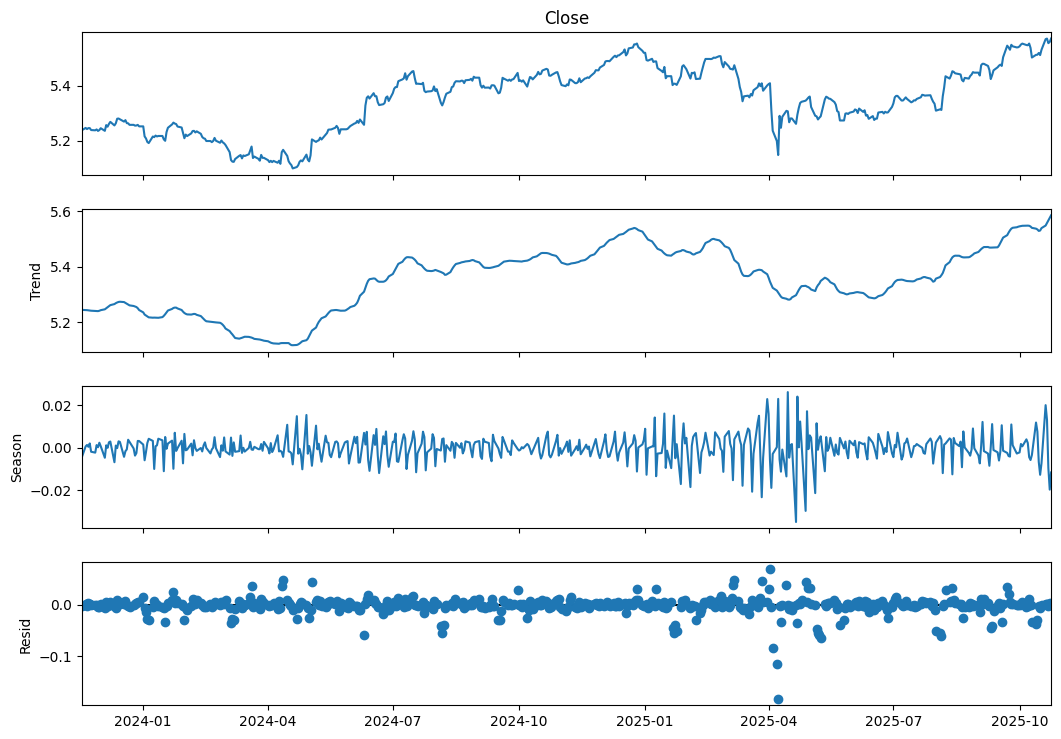

ADF on STL residual (should be closer to stationary):


,series,ADF stat,p-value,lags,nobs,crit 1%,crit 5%,crit 10%
0,STL residual,-10.598352,6.264151e-19,5,500,-3.443496,-2.867338,-2.569858


In [ ]:
# Choose a reasonable seasonal period:
# - weekly seasonality in trading days can be approximated by 5 business days
# - you can try 252 for annual trading-day seasonality, but it may be heavy
SEASONAL_PERIOD = 5

stl = STL(log_price.dropna(), period=SEASONAL_PERIOD, robust=True).fit()

fig = stl.plot()
fig.set_size_inches(12, 8)
plt.show()

resid = stl.resid
print("ADF on STL residual (should be closer to stationary):")
display(pd.DataFrame([adf_test(resid, "STL residual", regression="c")]))

## 5) Covariance vs Autocovariance, ACF and PACF

- Autocovariance: \(\gamma(h)=\mathrm{Cov}(X_t, X_{t-h})\)
- ACF: \(\rho(h)=\gamma(h)/\gamma(0)\)

We usually inspect ACF/PACF on a **stationary** series (often returns).


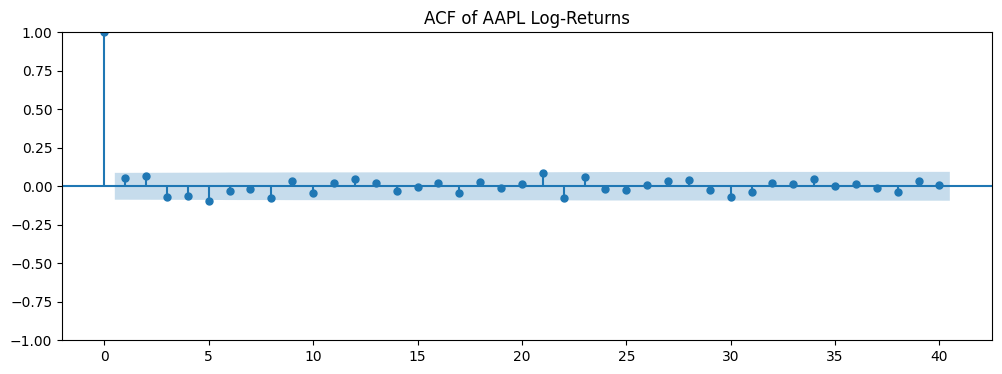

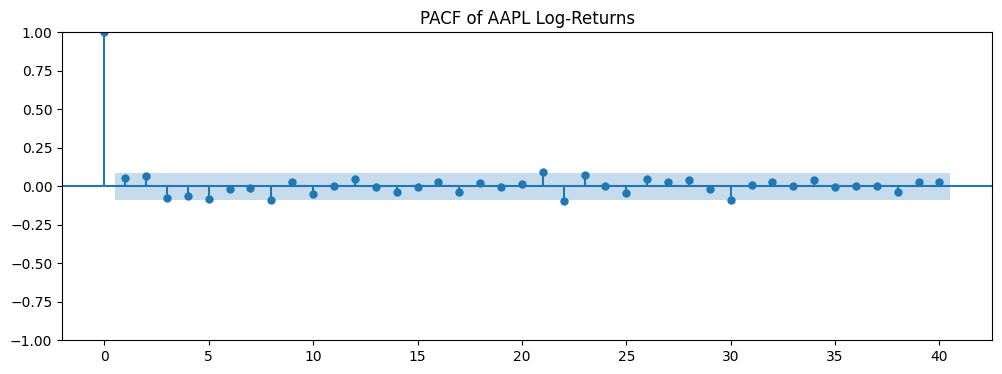

lag= 0  autocov= 0.000301
lag= 1  autocov= 0.000016
lag= 5  autocov=-0.000030
lag=10  autocov=-0.000013


In [ ]:
# Use log-returns (stationary-ish)
r = log_return.dropna()

plt.figure(figsize=(12,4))
plot_acf(r, lags=40, ax=plt.gca())
plt.title("ACF of AAPL Log-Returns")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(r, lags=40, ax=plt.gca(), method="ywm")
plt.title("PACF of AAPL Log-Returns")
plt.show()

# Sample autocovariance estimator (for teaching / transparency)
def sample_autocov(x, lag):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    T = len(x)
    xbar = x.mean()
    if lag >= T:
        return np.nan
    return (1/T) * np.sum((x[lag:] - xbar) * (x[:-lag] - xbar)) if lag > 0 else (1/T)*np.sum((x-xbar)**2)

for h in [0,1,5,10]:
    print(f"lag={h:2d}  autocov={sample_autocov(r.values, h): .6f}")

## 6) Indicators / Smoothing: SMA, CMA, EMA, RSI

These are **features** (not magic predictors). They summarize recent history:
- SMA: uniform weights  
- CMA: centered moving average (good for offline trend estimation)  
- EMA: exponentially decaying weights  
- RSI: momentum oscillator (0–100) based on average gains/losses


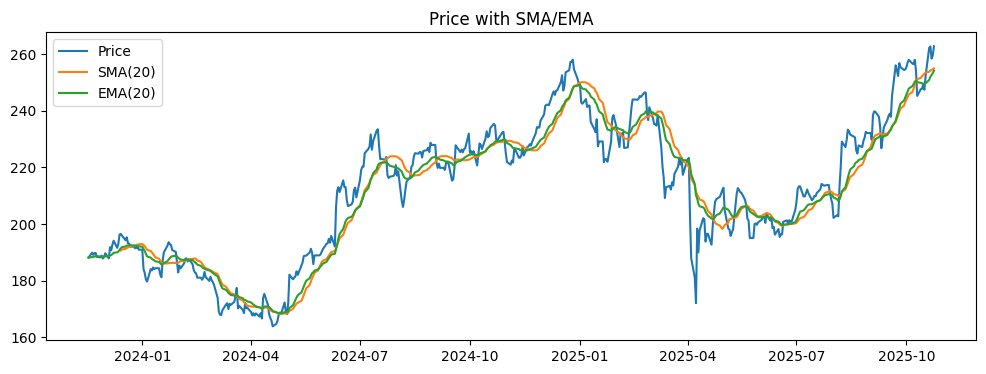

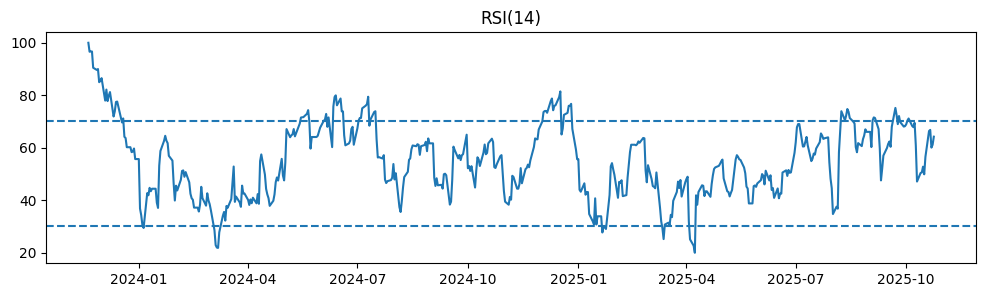

,log_return,SMA_20,EMA_20,RSI_14,was_missing
Date,,,,,
2025-10-13,0.009697,251.676499,249.898186,50.365844,0
2025-10-14,0.000444,252.157500,249.695502,50.518549,0
2025-10-15,0.006316,252.674999,249.661645,52.752823,0
2025-10-16,-0.007609,253.153499,249.451011,49.835518,0
2025-10-17,0.019371,253.492999,249.721391,56.473791,0
2025-10-20,0.038681,253.800999,250.913638,66.336226,0
2025-10-21,0.002019,254.217999,252.042815,66.768167,0
2025-10-22,-0.016577,254.524999,252.653024,60.009337,0
2025-10-23,0.004363,254.660499,253.312735,61.118057,0


In [ ]:
def SMA(x, n):
    return x.rolling(n).mean()

def CMA(x, n):
    # centered window; only usable when you have future values (offline)
    return x.rolling(n, center=True).mean()

def EMA(x, n):
    alpha = 2/(n+1)
    return x.ewm(alpha=alpha, adjust=False).mean()

def RSI(x, n=14):
    delta = x.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    # Wilder's smoothing can be approximated with EMA
    avg_gain = gain.ewm(alpha=1/n, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/n, adjust=False).mean()
    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))

df_feat = df.copy()
df_feat["log_price"] = log_price
df_feat["log_return"] = log_return
df_feat["SMA_20"] = SMA(price, 20)
df_feat["EMA_20"] = EMA(price, 20)
df_feat["CMA_21"] = CMA(price, 21)
df_feat["RSI_14"] = RSI(price, 14)

plt.figure(figsize=(12,4))
plt.plot(price, label="Price")
plt.plot(df_feat["SMA_20"], label="SMA(20)")
plt.plot(df_feat["EMA_20"], label="EMA(20)")
plt.title("Price with SMA/EMA")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(df_feat["RSI_14"])
plt.axhline(70, linestyle="--"); plt.axhline(30, linestyle="--")
plt.title("RSI(14)")
plt.show()

display(df_feat[["log_return","SMA_20","EMA_20","RSI_14","was_missing"]].tail(10))

## 7) Train/Validation/Test Split (Chronological) + Metrics

Time series rule: **never shuffle**.
We use a chronological split and fit scalers only on the training set (no leakage).


In [ ]:
def train_val_test_split(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train = df.iloc[:n_train].copy()
    val = df.iloc[n_train:n_train+n_val].copy()
    test = df.iloc[n_train+n_val:].copy()
    return train, val, test

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), 1e-12)
    return 100*np.mean(np.abs((y_true - y_pred) / denom))

def directional_accuracy(y_true, y_pred):
    y_true = pd.Series(y_true).dropna()
    y_pred = pd.Series(y_pred).dropna()
    common = y_true.index.intersection(y_pred.index)
    yt = y_true.loc[common].values
    yp = y_pred.loc[common].values
    return np.mean(np.sign(yt) == np.sign(yp))

# We'll forecast log_return (more stationary).
target = df_feat["log_return"].dropna().to_frame("y")

work = df_feat.copy()
work["y"] = df_feat["log_return"]

# Lags
for lag in [1,2,3,5,10]:
    work[f"y_lag{lag}"] = work["y"].shift(lag)

# Optional features
work["ema20_slope"] = work["EMA_20"].diff()
work["sma20_slope"] = work["SMA_20"].diff()
work["rsi14"] = work["RSI_14"]

if any(c.lower()=="volume" for c in work.columns):
    volcol = [c for c in work.columns if c.lower()=="volume"][0]
    work["vol_change"] = work[volcol].pct_change()


work.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with missing features/target
feature_cols = [
    c for c in work.columns
    if c.startswith("y_lag") or c in ["ema20_slope","sma20_slope","rsi14","vol_change","was_missing"]
]

data_ml = work[["y"] + feature_cols].dropna().copy()

train, val, test = train_val_test_split(data_ml)
print(train.shape, val.shape, test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_val = scaler.transform(val[feature_cols])
X_test = scaler.transform(test[feature_cols])

y_train = train["y"].values
y_val = val["y"].values
y_test = test["y"].values

print("Feature columns:", feature_cols)


(326, 11) (69, 11) (71, 11)
Feature columns: ['was_missing', 'y_lag1', 'y_lag2', 'y_lag3', 'y_lag5', 'y_lag10', 'ema20_slope', 'sma20_slope', 'rsi14', 'vol_change']


## 8) Simple Baselines (Linear / Ridge / Lasso)

Before deep models, always beat strong simple baselines.


In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "Lasso(alpha=1e-3)": Lasso(alpha=1e-3, max_iter=5000),
}

rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)
    rows.append({
        "model": name,
        "val_MAE": mean_absolute_error(y_val, pred_val),
        "val_RMSE": rmse(y_val, pred_val),
        "test_MAE": mean_absolute_error(y_test, pred_test),
        "test_RMSE": rmse(y_test, pred_test),
        "test_directional_acc": directional_accuracy(pd.Series(y_test, index=test.index),
                                                    pd.Series(pred_test, index=test.index))
    })

results_baseline = pd.DataFrame(rows).sort_values("test_RMSE")
display(results_baseline)

,model,val_MAE,val_RMSE,test_MAE,test_RMSE,test_directional_acc
1,Ridge(alpha=1.0),0.012437,0.021205,0.010226,0.012242,0.647887
0,LinearRegression,0.012623,0.021418,0.010388,0.012418,0.633803
2,Lasso(alpha=1e-3),0.011899,0.021799,0.009548,0.012476,0.676056


## 9) Classical Time Series Models: AR / MA / ARMA / ARIMA / SARIMA

We will model **log-returns** (more stationary).  
For price levels, ARIMA would usually require differencing.

Notes:
- AR(p): `AutoReg`
- MA(q): `ARIMA(order=(0,0,q))`
- ARMA(p,q): `ARIMA(order=(p,0,q))`
- ARIMA(p,d,q): `ARIMA(order=(p,d,q))`
- SARIMA: `SARIMAX(order=(p,d,q), seasonal_order=(P,D,Q,s))`


,model,MAE,RMSE,MAPE,DirectionalAcc
4,"SARIMA(2, 0, 2)x(1, 0, 1, 5)",0.011028,0.015959,9.865521e+01,0.493151
1,MA(5),0.011029,0.015961,1.250571e+07,0.452055
0,AR(5),0.011030,0.015962,2.059633e+07,0.452055
2,"ARMA(3,3)",0.011030,0.015962,2.519502e+07,0.452055
3,"ARIMA(3,0,3)",0.011030,0.015962,2.519502e+07,0.452055


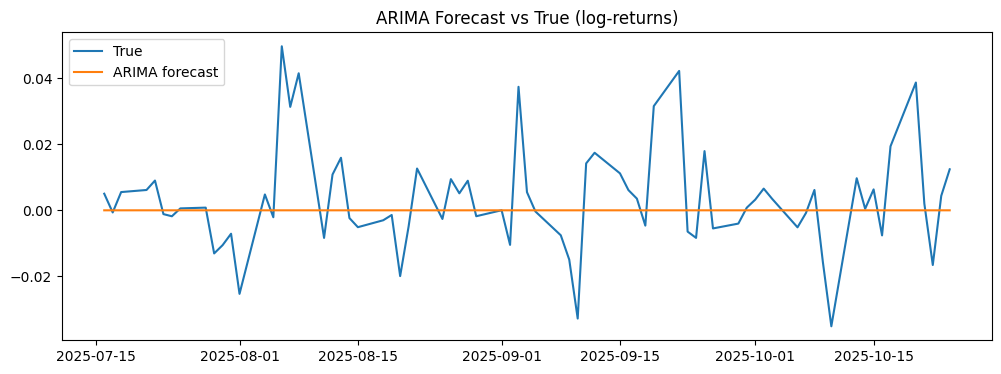

In [ ]:
series = df_feat["log_return"].dropna()

train_end = train.index[-1]
val_end = val.index[-1]

series_train = series.loc[:train_end]
series_val = series.loc[train_end:val_end]
series_test = series.loc[val_end:]

# Helper: forecast next steps
def eval_forecast(y_true, y_pred, name=""):
    return {
        "model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "DirectionalAcc": directional_accuracy(pd.Series(y_true, index=y_pred.index), y_pred),
    }

# ---- AR(p) ----
ar_p = 5
ar_model = AutoReg(series_train, lags=ar_p, old_names=False).fit()
ar_forecast = ar_model.predict(start=series_test.index[0], end=series_test.index[-1])
res_ar = eval_forecast(series_test.loc[ar_forecast.index], ar_forecast, f"AR({ar_p})")

# ---- MA(q) ----
ma_q = 5
ma_model = ARIMA(series_train, order=(0,0,ma_q)).fit()
ma_forecast = ma_model.get_prediction(start=series_test.index[0], end=series_test.index[-1]).predicted_mean
res_ma = eval_forecast(series_test.loc[ma_forecast.index], ma_forecast, f"MA({ma_q})")

# ---- ARMA(p,q) ----
arma_p, arma_q = 3, 3
arma_model = ARIMA(series_train, order=(arma_p,0,arma_q)).fit()
arma_forecast = arma_model.get_prediction(start=series_test.index[0], end=series_test.index[-1]).predicted_mean
res_arma = eval_forecast(series_test.loc[arma_forecast.index], arma_forecast, f"ARMA({arma_p},{arma_q})")

# ---- ARIMA(p,d,q) ----
# For log-returns we typically keep d=0
arima_p, arima_d, arima_q = 3, 0, 3
arima_model = ARIMA(series_train, order=(arima_p,arima_d,arima_q)).fit()
arima_forecast = arima_model.get_prediction(start=series_test.index[0], end=series_test.index[-1]).predicted_mean
res_arima = eval_forecast(series_test.loc[arima_forecast.index], arima_forecast, f"ARIMA({arima_p},{arima_d},{arima_q})")

# ---- SARIMA ----
# Daily (business-day) log-returns don't have strong seasonality, but weekly (5) can be tested.
sarima_order = (2,0,2)
seasonal_order = (1,0,1,5)   # (P,D,Q,s)
sarima_model = SARIMAX(series_train, order=sarima_order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_forecast = sarima_model.get_prediction(start=series_test.index[0], end=series_test.index[-1]).predicted_mean
res_sarima = eval_forecast(series_test.loc[sarima_forecast.index], sarima_forecast,
                           f"SARIMA{sarima_order}x{seasonal_order}")

results_classical = pd.DataFrame([res_ar,res_ma,res_arma,res_arima,res_sarima]).sort_values("RMSE")
display(results_classical)

# Plot one example
plt.figure(figsize=(12,4))
plt.plot(series_test, label="True")
plt.plot(arima_forecast, label="ARIMA forecast")
plt.title("ARIMA Forecast vs True (log-returns)")
plt.legend()
plt.show()

## 10) Walk-Forward Validation 

Walk-forward is the correct way to compare models in time series:
- Expanding window: training set grows over time.
- Rolling window: fixed-length training window (adapts to regime changes).


In [ ]:
def walk_forward_arima(series, order=(2,0,2), start_train_size=500, step=20):
    series = series.dropna()
    preds = []
    trues = []
    idxs = []

    for end in tqdm(range(start_train_size, len(series)-1, step)):
        train_slice = series.iloc[:end]
        test_slice = series.iloc[end:end+step]
        model = ARIMA(train_slice, order=order).fit()
        fc = model.forecast(steps=len(test_slice))
        preds.append(fc)
        trues.append(test_slice)
        idxs.append(test_slice.index)

    y_pred = pd.concat(preds).sort_index()
    y_true = pd.concat(trues).sort_index()
    return y_true, y_pred

# Example run (can be slow on long datasets). Uncomment if needed.
# y_true_wf, y_pred_wf = walk_forward_arima(series, order=(2,0,2), start_train_size=600, step=25)
# print("Walk-forward RMSE:", rmse(y_true_wf, y_pred_wf))

## 11) Deep Learning Setup (PyTorch)

We forecast *next-step log-return* using a sliding window:

- Input: last **L** steps of features  
- Output: next **H** steps of target (here we use H=1 by default)

We apply:
- chronological split
- scaling fit on train only
- early stopping
- gradient clipping (to reduce exploding gradients)


In [ ]:
# Build multivariate feature matrix for neural nets
# We'll include: log_return + RSI + volume change (if present) + was_missing
nn_df = df_feat.copy()
nn_df["y"] = nn_df["log_return"]
nn_df["rsi14"] = nn_df["RSI_14"]
nn_df["ema20_slope"] = nn_df["EMA_20"].diff()
nn_df["was_missing"] = nn_df["was_missing"].astype(float)

if any(c.lower()=="volume" for c in nn_df.columns):
    volcol = [c for c in nn_df.columns if c.lower()=="volume"][0]
    nn_df["vol_change"] = nn_df[volcol].pct_change()
else:
    nn_df["vol_change"] = 0.0


nn_df.replace([np.inf, -np.inf], np.nan, inplace=True)

nn_df = nn_df[["y","rsi14","ema20_slope","vol_change","was_missing"]].dropna().copy()

train_nn, val_nn, test_nn = train_val_test_split(nn_df)

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(train_nn.drop(columns=["y"]))
X_val_nn = scaler_nn.transform(val_nn.drop(columns=["y"]))
X_test_nn = scaler_nn.transform(test_nn.drop(columns=["y"]))

y_train_nn = train_nn["y"].values
y_val_nn = val_nn["y"].values
y_test_nn = test_nn["y"].values

feature_names_nn = list(train_nn.drop(columns=["y"]).columns)
print("NN features:", feature_names_nn)

NN features: ['rsi14', 'ema20_slope', 'vol_change', 'was_missing']


In [ ]:
class WindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, L: int = 60, H: int = 1):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        self.L = L
        self.H = H

    def __len__(self):
        return len(self.X) - self.L - self.H + 1

    def __getitem__(self, i):
        x_win = self.X[i:i+self.L]                # (L, d)
        y_win = self.y[i+self.L:i+self.L+self.H]  # (H, 1)
        return x_win, y_win

L = 60   # lookback length
H = 1    # forecast horizon

ds_train = WindowDataset(X_train_nn, y_train_nn, L=L, H=H)
ds_val   = WindowDataset(X_val_nn, y_val_nn, L=L, H=H)
ds_test  = WindowDataset(X_test_nn, y_test_nn, L=L, H=H)

dl_train = DataLoader(ds_train, batch_size=64, shuffle=False)
dl_val   = DataLoader(ds_val, batch_size=64, shuffle=False)
dl_test  = DataLoader(ds_test, batch_size=64, shuffle=False)

print("Train batches:", len(dl_train), "Val:", len(dl_val), "Test:", len(dl_test))

Train batches: 5 Val: 1 Test: 1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def train_model(model, dl_train, dl_val, epochs=15, lr=1e-3, clip_norm=1.0, patience=3):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in dl_train:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in dl_val:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_losses.append(loss_fn(pred, yb).item())

        tr = float(np.mean(train_losses))
        va = float(np.mean(val_losses))
        print(f"Epoch {epoch:02d} | train={tr:.6f} | val={va:.6f}")

        if va < best_val - 1e-6:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping ✅")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def predict_model(model, dl):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            pred = model(xb).detach().cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    return np.vstack(preds).squeeze(), np.vstack(trues).squeeze()

Device: cpu


## 12) RNN and LSTM Forecasters

Vanilla RNN can struggle with long sequences due to vanishing/exploding gradients.  
LSTM usually works better because of gating + cell state (memory).


In [ ]:
class RNNForecaster(nn.Module):
    def __init__(self, d_in, hidden=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size=d_in, hidden_size=hidden, num_layers=num_layers,
                          batch_first=True, nonlinearity="tanh")
        self.head = nn.Linear(hidden, 1)

    def forward(self, x):
        # x: (B, L, d)
        out, _ = self.rnn(x)      # out: (B, L, hidden)
        last = out[:, -1, :]      # use last time step representation
        return self.head(last).unsqueeze(1)  # (B, 1, 1) to match y shape (B, H, 1)

class LSTMForecaster(nn.Module):
    def __init__(self, d_in, hidden=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=d_in, hidden_size=hidden, num_layers=num_layers,
                            batch_first=True)
        self.head = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last).unsqueeze(1)

d_in = X_train_nn.shape[1]

rnn = RNNForecaster(d_in=d_in, hidden=64)
lstm = LSTMForecaster(d_in=d_in, hidden=64)

rnn = train_model(rnn, dl_train, dl_val, epochs=15, lr=1e-3, clip_norm=1.0, patience=3)
lstm = train_model(lstm, dl_train, dl_val, epochs=15, lr=1e-3, clip_norm=1.0, patience=3)

pred_rnn, true_rnn = predict_model(rnn, dl_test)
pred_lstm, true_lstm = predict_model(lstm, dl_test)

print("RNN  test RMSE:", rmse(true_rnn, pred_rnn))
print("LSTM test RMSE:", rmse(true_lstm, pred_lstm))

Epoch 01 | train=0.004211 | val=0.003298
Epoch 02 | train=0.002607 | val=0.001586
Epoch 03 | train=0.000645 | val=0.000420
Epoch 04 | train=0.000918 | val=0.000501
Epoch 05 | train=0.000546 | val=0.000252
Epoch 06 | train=0.000367 | val=0.000563
Epoch 07 | train=0.000439 | val=0.000229
Epoch 08 | train=0.000293 | val=0.000130
Epoch 09 | train=0.000311 | val=0.000142
Epoch 10 | train=0.000272 | val=0.000198
Epoch 11 | train=0.000266 | val=0.000194
Early stopping ✅
Epoch 01 | train=0.008206 | val=0.001543
Epoch 02 | train=0.000878 | val=0.000734
Epoch 03 | train=0.001352 | val=0.001298
Epoch 04 | train=0.001004 | val=0.000315
Epoch 05 | train=0.000495 | val=0.000091
Epoch 06 | train=0.000449 | val=0.000156
Epoch 07 | train=0.000371 | val=0.000147
Epoch 08 | train=0.000316 | val=0.000157
Early stopping ✅
RNN  test RMSE: 0.019324918247763768
LSTM test RMSE: 0.01748832890207122


## 13) 1D CNN Forecaster (Local Patterns)

1D CNNs are good at learning local motifs (short windows) efficiently.


In [ ]:
class CNN1DForecaster(nn.Module):
    def __init__(self, d_in, channels=64, kernel=5):
        super().__init__()
        # Conv1d expects (B, C_in, L). We'll treat features as channels by transposing.
        self.conv1 = nn.Conv1d(in_channels=d_in, out_channels=channels, kernel_size=kernel, padding=kernel//2)
        self.act = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel, padding=kernel//2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(channels, 1)

    def forward(self, x):
        # x: (B, L, d) -> (B, d, L)
        x = x.transpose(1, 2)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # (B, channels)
        return self.head(x).unsqueeze(1)

cnn = CNN1DForecaster(d_in=d_in, channels=64, kernel=5)
cnn = train_model(cnn, dl_train, dl_val, epochs=15, lr=1e-3, clip_norm=1.0, patience=3)

pred_cnn, true_cnn = predict_model(cnn, dl_test)
print("CNN test RMSE:", rmse(true_cnn, pred_cnn))

Epoch 01 | train=0.005910 | val=0.000560
Epoch 02 | train=0.005572 | val=0.009530
Epoch 03 | train=0.002645 | val=0.000880
Epoch 04 | train=0.001099 | val=0.000478
Epoch 05 | train=0.001103 | val=0.000068
Epoch 06 | train=0.000711 | val=0.000325
Epoch 07 | train=0.000497 | val=0.000149
Epoch 08 | train=0.000348 | val=0.000375
Early stopping ✅
CNN test RMSE: 0.04306590275675586


## 14) Transformer Encoder Forecaster (Global Dependencies)

Transformers use **self-attention** so each time step can “look at” every other time step in the window.

For forecasting, we keep things simple:
- project input features into `d_model`
- add positional encoding
- TransformerEncoder
- predict next-step output


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, L, d_model)
        L = x.size(1)
        return x + self.pe[:, :L]

class TransformerForecaster(nn.Module):
    def __init__(self, d_in, d_model=64, nhead=4, num_layers=2, dim_ff=128, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(d_in, d_model)
        self.pos = PositionalEncoding(d_model=d_model, max_len=5000)

        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=dim_ff,
                                               dropout=dropout,
                                               batch_first=True,
                                               activation="gelu")
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, L, d_in)
        z = self.proj(x)          # (B, L, d_model)
        z = self.pos(z)
        z = self.encoder(z)       # (B, L, d_model)
        last = z[:, -1, :]        # take representation at last step
        return self.head(last).unsqueeze(1)

transformer = TransformerForecaster(d_in=d_in, d_model=64, nhead=4, num_layers=2, dim_ff=128)
transformer = train_model(transformer, dl_train, dl_val, epochs=20, lr=1e-3, clip_norm=1.0, patience=4)

pred_tr, true_tr = predict_model(transformer, dl_test)
print("Transformer test RMSE:", rmse(true_tr, pred_tr))

Epoch 01 | train=0.271343 | val=0.040142
Epoch 02 | train=0.053514 | val=0.017769
Epoch 03 | train=0.070790 | val=0.010648
Epoch 04 | train=0.036050 | val=0.013852
Epoch 05 | train=0.015172 | val=0.001873
Epoch 06 | train=0.010005 | val=0.008606
Epoch 07 | train=0.012339 | val=0.001674
Epoch 08 | train=0.007977 | val=0.005244
Epoch 09 | train=0.005693 | val=0.000168
Epoch 10 | train=0.004024 | val=0.000488
Epoch 11 | train=0.003870 | val=0.001078
Epoch 12 | train=0.004522 | val=0.000346
Epoch 13 | train=0.003679 | val=0.001957
Early stopping ✅
Transformer test RMSE: 0.025540274219716108


## 15) D-Linear Baseline (Decomposition + Linear)

D-Linear idea:
1) Decompose input into **trend** (moving average) + **remainder**
2) Use simple linear layers to forecast each
3) Add them back

This is a great baseline for **chaotic financial data** (often beats over-parameterized models).


In [ ]:
class DLinear(nn.Module):
    def __init__(self, d_in, L, H=1, ma_window=25):
        super().__init__()
        self.L = L
        self.H = H
        self.ma_window = ma_window

        # Linear layers to map (L -> H) for each feature channel.
        # We'll use a single shared projection for simplicity.
        self.linear_trend = nn.Linear(L, H)
        self.linear_resid = nn.Linear(L, H)

        # Learnable mixing to produce final y
        self.mix = nn.Linear(d_in, 1)

        # Moving average implemented with Conv1d over time
        # We'll apply it independently per feature by grouping.
        self.pad = ma_window // 2
        self.avg = nn.AvgPool1d(kernel_size=ma_window, stride=1, padding=0)

    def moving_avg(self, x):
        # x: (B, L, d) -> (B, d, L)
        x = x.transpose(1,2)
        # manual padding for centered MA
        x_pad = nn.functional.pad(x, (self.pad, self.pad), mode="replicate")
        ma = self.avg(x_pad)  # (B, d, L)
        return ma.transpose(1,2)  # (B, L, d)

    def forward(self, x):
        # x: (B, L, d)
        trend = self.moving_avg(x)
        resid = x - trend

        # project along time dimension L -> H
        # transpose to (B, d, L) so Linear(L->H) applies to last dim
        trend_t = trend.transpose(1,2)
        resid_t = resid.transpose(1,2)

        trend_fc = self.linear_trend(trend_t)  # (B, d, H)
        resid_fc = self.linear_resid(resid_t)  # (B, d, H)

        out = trend_fc + resid_fc              # (B, d, H)
        out = out.transpose(1,2)               # (B, H, d)
        yhat = self.mix(out).squeeze(-1)       # (B, H)
        return yhat.unsqueeze(-1)              # (B, H, 1)

dlinear = DLinear(d_in=d_in, L=L, H=H, ma_window=25)
dlinear = train_model(dlinear, dl_train, dl_val, epochs=20, lr=1e-3, clip_norm=1.0, patience=4)

pred_dl, true_dl = predict_model(dlinear, dl_test)
print("D-Linear test RMSE:", rmse(true_dl, pred_dl))

Epoch 01 | train=0.051564 | val=0.027162
Epoch 02 | train=0.043841 | val=0.025585
Epoch 03 | train=0.037702 | val=0.024004
Epoch 04 | train=0.032642 | val=0.022419
Epoch 05 | train=0.028455 | val=0.020826
Epoch 06 | train=0.024961 | val=0.019231
Epoch 07 | train=0.022008 | val=0.017650
Epoch 08 | train=0.019471 | val=0.016104
Epoch 09 | train=0.017255 | val=0.014615
Epoch 10 | train=0.015294 | val=0.013206
Epoch 11 | train=0.013542 | val=0.011891
Epoch 12 | train=0.011970 | val=0.010682
Epoch 13 | train=0.010559 | val=0.009582
Epoch 14 | train=0.009293 | val=0.008591
Epoch 15 | train=0.008163 | val=0.007704
Epoch 16 | train=0.007156 | val=0.006913
Epoch 17 | train=0.006264 | val=0.006208
Epoch 18 | train=0.005477 | val=0.005580
Epoch 19 | train=0.004784 | val=0.005019
Epoch 20 | train=0.004176 | val=0.004518
D-Linear test RMSE: 0.08808288473772853


## 16) Compare Deep Models (Test RMSE)

This table compares the deep models we trained on the same target and split.


,model,RMSE
1,LSTM,0.017488
0,RNN,0.019325
3,Transformer,0.025540
2,CNN1D,0.043066
4,D-Linear,0.088083


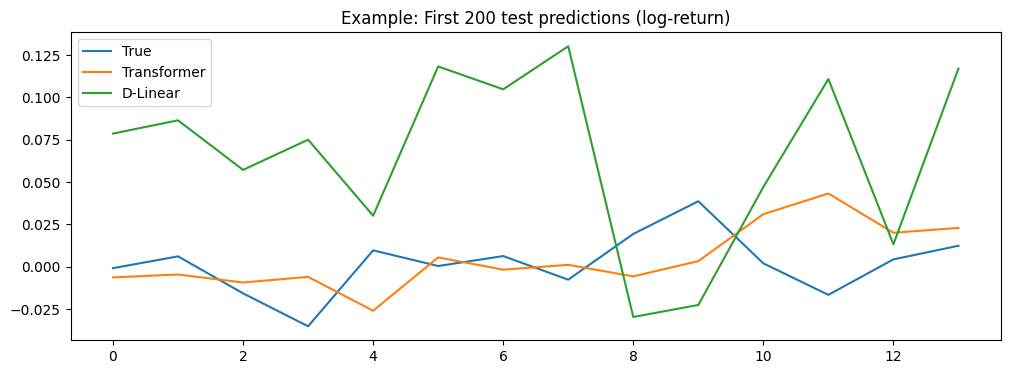

In [ ]:
deep_results = pd.DataFrame([
    {"model":"RNN", "RMSE": rmse(true_rnn, pred_rnn)},
    {"model":"LSTM", "RMSE": rmse(true_lstm, pred_lstm)},
    {"model":"CNN1D", "RMSE": rmse(true_cnn, pred_cnn)},
    {"model":"Transformer", "RMSE": rmse(true_tr, pred_tr)},
    {"model":"D-Linear", "RMSE": rmse(true_dl, pred_dl)},
]).sort_values("RMSE")

display(deep_results)

# Plot a short segment of predictions to visually compare
k = 200
plt.figure(figsize=(12,4))
plt.plot(true_tr[:k], label="True")
plt.plot(pred_tr[:k], label="Transformer")
plt.plot(pred_dl[:k], label="D-Linear")
plt.title("Example: First 200 test predictions (log-return)")
plt.legend()
plt.show()

## 17) Multivariate & Cross-Correlation 

If you have **multiple series** (e.g., AAPL + SPY), you can compute cross-correlation across lags:

\[
\rho_{xy}(h)=\frac{\gamma_{xy}(h)}{\sqrt{\gamma_{xx}(0)\gamma_{yy}(0)}}
\]

Here we demonstrate using:
- AAPL log-returns (x)
- Volume change (y) as a second series (if volume exists)

You can replace `y_series` with another ticker return series if you have it.


In [ ]:
x_series = df_feat["log_return"].dropna()

if any(c.lower()=="volume" for c in df_feat.columns):
    volcol = [c for c in df_feat.columns if c.lower()=="volume"][0]
    y_series = df_feat[volcol].pct_change().dropna()
else:
    # fallback: use EMA slope as a second series
    y_series = df_feat["EMA_20"].diff().dropna()

# align
xy = pd.concat([x_series.rename("x"), y_series.rename("y")], axis=1).dropna()
x = xy["x"].values
y = xy["y"].values

def cross_corr(x, y, max_lag=40):
    out = []
    for h in range(-max_lag, max_lag+1):
        if h < 0:
            out.append(np.corrcoef(x[:h], y[-h:])[0,1])
        elif h > 0:
            out.append(np.corrcoef(x[h:], y[:-h])[0,1])
        else:
            out.append(np.corrcoef(x, y)[0,1])
    lags = np.arange(-max_lag, max_lag+1)
    return pd.Series(out, index=lags)

cc = cross_corr(x, y, max_lag=40)

display(cc.abs().sort_values(ascending=False).head(10))

,0
-40,NaN
-39,NaN
-38,NaN
-37,NaN
-36,NaN
-35,NaN
-34,NaN
-33,NaN
-32,NaN
-31,NaN


## 18) Granger Causality Test 

Granger causality asks:

> Do past values of `y` help predict `x` beyond past values of `x` alone?

Important cautions:
- Use **stationary** series (returns/differences) to reduce spurious results.
- “Granger causality” is not true causal proof; it’s predictive causality within a VAR-style framework.


In [ ]:
# We'll test whether y Granger-causes x using stationary-ish series.
# This can be slow; keep maxlag small (e.g., 5).
# The function prints results for each lag.

data_gc = xy[["x","y"]].dropna()

data_gc.replace([np.inf, -np.inf], np.nan, inplace=True)
data_gc.dropna(inplace=True)

maxlag = 5

# grangercausalitytests expects columns ordered as [x, y] if testing y->x via the 'ssr_ftest'
print("Testing: does y Granger-cause x ?")
grangercausalitytests(data_gc[["x","y"]], maxlag=maxlag, verbose=True)


Testing: does y Granger-cause x ?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4314  , p=0.5116  , df_denom=480, df_num=1
ssr based chi2 test:   chi2=0.4341  , p=0.5100  , df=1
likelihood ratio test: chi2=0.4339  , p=0.5101  , df=1
parameter F test:         F=0.4314  , p=0.5116  , df_denom=480, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3850  , p=0.6807  , df_denom=477, df_num=2
ssr based chi2 test:   chi2=0.7780  , p=0.6777  , df=2
likelihood ratio test: chi2=0.7774  , p=0.6779  , df=2
parameter F test:         F=0.3850  , p=0.6807  , df_denom=477, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5764  , p=0.6308  , df_denom=474, df_num=3
ssr based chi2 test:   chi2=1.7547  , p=0.6248  , df=3
likelihood ratio test: chi2=1.7515  , p=0.6255  , df=3
parameter F test:         F=0.5764  , p=0.6308  , df_denom=474, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

{np.int64(1): ({'ssr_ftest': (np.float64(0.43139534207390756),
    np.float64(0.5116198400980297),
    np.float64(480.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.43409156296186946),
    np.float64(0.5099880798951495),
    np.int64(1)),
   'lrtest': (np.float64(0.43389661196988527),
    np.float64(0.5100831082025232),
    np.int64(1)),
   'params_ftest': (np.float64(0.43139534207401325),
    np.float64(0.5116198400979777),
    np.float64(480.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.3849667802683864),
    np.float64(0.6806844631650064),
    np.float64(477.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.7780041429323364),
    np.float64(0.6777328661118138),
    np.int64(2)),
   'lrtest': (np.float64(0.777376923124848),
    np.float64(0.6779454431821145),
    np.int64(2)),
   'params_ftest': (np.float64(0.3849667802683674),
    np.float64(0.6806844631650246),
    np.float64(477.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
   